In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from src.configspace import (
    COX_PH_CONFIGSPACE,
    GB_COX_CONFIGSPACE,
    GPR_CONFIGSPACE,
    POLY_RIDGE_CONFIGSPACE,
    RANDOM_FOREST_CONFIGSPACE,
    RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    RIDGE_CONFIGSPACE,
    SVR,
    SVR_CONFIGSPACE,
    XGB_AFT_CONFIGSPACE,
    XGB_CONFIGSPACE,
    CoxPHSurvivalAnalysis,
    GPRWithRBF,
    GradientBoostingSurvivalAnalysis,
    PolynomialRidge,
    RandomForestRegressor,
    RandomSurvivalForest,
    Ridge,
    XGBRegressor,
    XGBRegressorAFT,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.split import get_n_splits
from src.survival_function_wrapper import SurvivalFunctionWrapper
from src.wrapper import ScikitLearnWrapper, SkipCutOffScikitLearnWrapper
from src.xgb_wrapper import XGBwrapper

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [3]:
CONST_CUT_OFF = 1

In [4]:
N_TRIALS = 500
N = 3
INSTANCE_NUMBER = 10
SOLVER_NUMBER = 90
RANDOM_STATE = 0

SPLITS = get_n_splits(
    df=df,
    n=N,
    instance_number=INSTANCE_NUMBER,
    solver_number=SOLVER_NUMBER,
    random_state=RANDOM_STATE,
)

### Ridge

In [5]:
ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

[INFO][abstract_initial_design.py:147] Using 20 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 50e02f as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 0874a8 and rejected config 50e02f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 90b7a3 and rejected config 0874a8 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 178a0c and rejected config 90b7a3 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 85028a and rejected config 178a0c as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 8fccd9 and rejecte

### PolynomialRidge

In [6]:
poly_ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

poly_ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

[INFO][abstract_initial_design.py:147] Using 30 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0f550a as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config a3d22f and rejected config 0f550a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config ccf945 and rejected config a3d22f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 6db2ea and rejected config ccf945 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 091618 and rejected config 6db2ea as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config ff4ff2 and rejecte

### RandomForestRegressor

In [7]:
rf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

rf_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

[INFO][abstract_initial_design.py:147] Using 70 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config f8a6b5 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 286ac7 and rejected config f8a6b5 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 4ef6d2 and rejected config 286ac7 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 3b886b and rejected config 4ef6d2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config 8f00a9 and rejected config 3b886b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier

### XGBRegressor

In [8]:
xgb_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

xgb_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

[INFO][abstract_initial_design.py:147] Using 100 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0610fc as new incumbent because there are no incumbents yet.
[INFO][smbo.py:320] Finished 50 trials.
[INFO][smbo.py:320] Finished 100 trials.
[INFO][smbo.py:320] Finished 150 trials.
[INFO][smbo.py:320] Finished 200 trials.
[INFO][smbo.py:320] Finished 250 trials.
[INFO][smbo.py:320] Finished 300 trials.
[INFO][smbo.py:320] Finished 350 trials.
[INFO][smbo.py:320] Finished 400 trials.
[INFO][smbo.py:320] Finished 450 trials.
[INFO][smbo.py:320] Finished 500 trials.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0
[INFO][abstract_initial_design.py:147] Using 100 initial design configurations and 0

### SVR

In [9]:
svr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=ScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

svr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

[INFO][abstract_initial_design.py:147] Using 60 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 383a37 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 6936c6 and rejected config 383a37 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 781074 and rejected config 6936c6 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config 4419a0 and rejected config 781074 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 2864a9 and rejected config 4419a0 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier

### GPRWithRBF

In [10]:
gpr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=ScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

gpr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)

[INFO][abstract_initial_design.py:147] Using 30 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0b9b43 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 9b01d2 and rejected config 0b9b43 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config f1ca9b and rejected config 9b01d2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config f0baae and rejected config f1ca9b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 7fb742 and rejected config f0baae as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 936a3c and rejecte

### CoxPHSurvivalAnalysis

In [11]:
coxph_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=CoxPHSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=COX_PH_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)
coxph_incumbent

[INFO][abstract_initial_design.py:147] Using 50 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 2f56c8 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 74888f and rejected config 2f56c8 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config dcaff5 and rejected config 74888f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config 10a7c9 and rejected config dcaff5 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 938caf and rejected config 10a7c9 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier

{'alpha': 16.6270761931804,
 'risk_function': 'par10',
 'ties': 'efron',
 'model_cls': sksurv.linear_model.coxph.CoxPHSurvivalAnalysis}

### RandomSurvivalForest

In [12]:
rsf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomSurvivalForest,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)
rsf_incumbent

[INFO][abstract_initial_design.py:147] Using 90 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 20fae2 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config 4f486c and rejected config 20fae2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config d58df5 and rejected config 4f486c as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 04fc1d and rejected config d58df5 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config b41ac9 and rejected config 04fc1d as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finishe

{'max_depth': 14,
 'max_features': 0.9994619626558,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_jobs': -1,
 'random_state': 0,
 'risk_function': 'par10',
 'model_cls': sksurv.ensemble.forest.RandomSurvivalForest}

In [12]:
rsf_incumbent = {'max_depth': 14,
 'max_features': 0.9994619626558,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_jobs': -1,
 'random_state': 0,
 'risk_function': 'par10',
 'model_cls': RandomSurvivalForest}

### GradientBoostingSurvivalAnalysis

In [13]:
gb_cox_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GradientBoostingSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=GB_COX_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)
gb_cox_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 130 to 125 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 125 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 7e620a as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config cbfb86 and rejected config 7e620a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][smbo.py:320] Finished 100 trials.
[INFO][abstract_intensifier.py:595] Added config db5d27 and rejected config cbfb86 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 150 trials.
[INFO][smbo.py:320] Finished 200 trials.
[INFO][abstract_intensifier.py:595] Added config ec7a48 and rejected config db5d27 as incumbent 

{'ccp_alpha': 0.0010141162662,
 'learning_rate': 0.0408766986133,
 'loss': 'coxph',
 'max_depth': 9,
 'max_features': 0.783730598812,
 'min_samples_leaf': 9,
 'min_samples_split': 3,
 'n_estimators': 778,
 'random_state': 0,
 'risk_function': 'par10',
 'subsample': 0.7720667371046,
 'model_cls': sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis}

In [13]:
gb_cox_incumbent = {'ccp_alpha': 0.0010141162662,
 'learning_rate': 0.0408766986133,
 'loss': 'coxph',
 'max_depth': 9,
 'max_features': 0.783730598812,
 'min_samples_leaf': 9,
 'min_samples_split': 3,
 'n_estimators': 778,
 'random_state': 0,
 'risk_function': 'par10',
 'subsample': 0.7720667371046,
 'model_cls': GradientBoostingSurvivalAnalysis}

### XGBRegressorAFT

In [14]:
xgb_aft_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressorAFT,
    wrapper_cls=XGBwrapper,
    configspace=XGB_AFT_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)
xgb_aft_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 140 to 125 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 125 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 1f402b as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config e58b16 and rejected config 1f402b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 38ddd0 and rejected config e58b16 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 1b7713 and rejected config 38ddd0 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 5243fc and rejected config 1b7713 as incumbent becaus

{'aft_loss_distribution': 'logistic',
 'colsample_bytree': 0.9297991817873,
 'eval_metric': 'aft-nloglik',
 'gamma': 1.4753684154123,
 'learning_rate': 0.0879371729785,
 'max_depth': 11,
 'min_child_weight': 1,
 'num_boost_round': 504,
 'objective': 'survival:aft',
 'reg_alpha': 0.0018147604226,
 'reg_lambda': 0.0027264311064,
 'seed': 0,
 'subsample': 0.7029603530202,
 'aft_loss_distribution_scale': 1.1531066300003,
 'model_cls': src.configspace.XGBRegressorAFT}

In [14]:
xgb_aft_incumbent = {'aft_loss_distribution': 'logistic',
 'colsample_bytree': 0.9297991817873,
 'eval_metric': 'aft-nloglik',
 'gamma': 1.4753684154123,
 'learning_rate': 0.0879371729785,
 'max_depth': 11,
 'min_child_weight': 1,
 'num_boost_round': 504,
 'objective': 'survival:aft',
 'reg_alpha': 0.0018147604226,
 'reg_lambda': 0.0027264311064,
 'seed': 0,
 'subsample': 0.7029603530202,
 'aft_loss_distribution_scale': 1.1531066300003,
 'model_cls': XGBRegressorAFT}

## Comparison

In [18]:
model_info_list = [
    # include cut-off
    {
        "wrapper": ScikitLearnWrapper(**ridge_incumbent),
        "name": "Ridge Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**poly_ridge_incumbent),
        "name": "Polynomial Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**rf_incumbent),
        "name": "Random Forest"
    },
    {
        "wrapper": ScikitLearnWrapper(**xgb_incumbent),
        "name": "XGBoost"
    },
    # skip cut-off
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**ridge_incumbent_skip_cutoff),
        "name": "Ridge Regression"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**poly_ridge_incumbent_skip_cutoff),
        "name": "Polynomial Regression"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**svr_incumbent_skip_cutoff),
        "name": "Support Vector Regression"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**gpr_incumbent_skip_cutoff),
        "name": "Gaussian Process Regression"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**rf_incumbent_skip_cutoff),
        "name": "Random Forest"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**xgb_incumbent_skip_cutoff),
        "name": "XGBoost"
    },
    # survival models
    {
        "wrapper": SurvivalFunctionWrapper(**coxph_incumbent),
        "name": "Cox PH"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**rsf_incumbent),
        "name": "Random Survival Forest"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**gb_cox_incumbent),
        "name": "Gradient Boosting Cox"
    },
    {
        "wrapper": XGBwrapper(**xgb_aft_incumbent),
        "name": "XGBoost AFT"
    },
]
 
# random_state_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
random_state_list = [1]
solver_number_list = [5, 10, 15, 20, 30, 50, 70, 100, 150, 200, 300, 500]
total_iterations = len(random_state_list) * len(solver_number_list) * len(model_info_list)
pbar = tqdm(total=total_iterations, desc="Evaluating models")

records = []

for random_state in random_state_list:
    for solver_number in solver_number_list:
        pbar.set_description(f"RS={random_state}, Solvers={solver_number}")
        splits = get_n_splits(
            df,
            n=5,
            instance_number=10,
            solver_number=solver_number,
            random_state=random_state,
        )
        for model_info in model_info_list:
            pbar.set_postfix(model=model_info["name"])

            result = evaluate_model_with_cross_validation(
                df,
                wrapper=model_info["wrapper"],
                splits=splits,
                const_cut_off=CONST_CUT_OFF,
                random_state=random_state,
            )
            result["random_state"] = random_state
            result["solver_number"] = solver_number
            result["name"] = model_info["name"]
            records.append(result)
            pbar.update(1)

pbar.close()
result_df = pd.DataFrame(records)

Evaluating models:   0%|          | 0/192 [00:00<?, ?it/s]

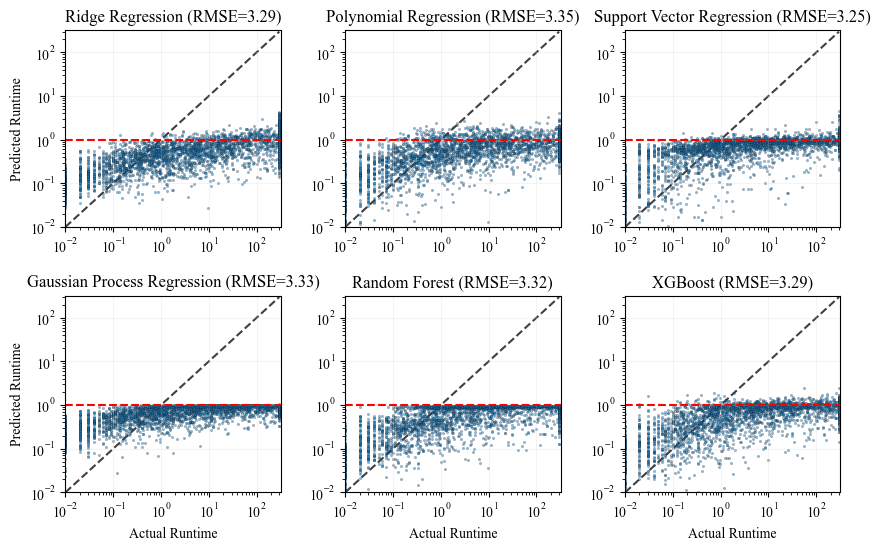

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axs = axs.flatten()

plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[:6].reset_index(drop=True)

for i, result in plot_df.iterrows():
    ax = axs[i]

    sc = ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=3,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{result["name"]} (RMSE={result["rmse"]:.2f})')
    ax.axhline(y=1, color='red', linestyle='--')

axs[0].set_ylabel("Predicted Runtime")
axs[3].set_ylabel("Predicted Runtime")
axs[3].set_xlabel("Actual Runtime")
axs[4].set_xlabel("Actual Runtime")
axs[5].set_xlabel("Actual Runtime")
plt.subplots_adjust(wspace=0.3, hspace=0.35)
plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

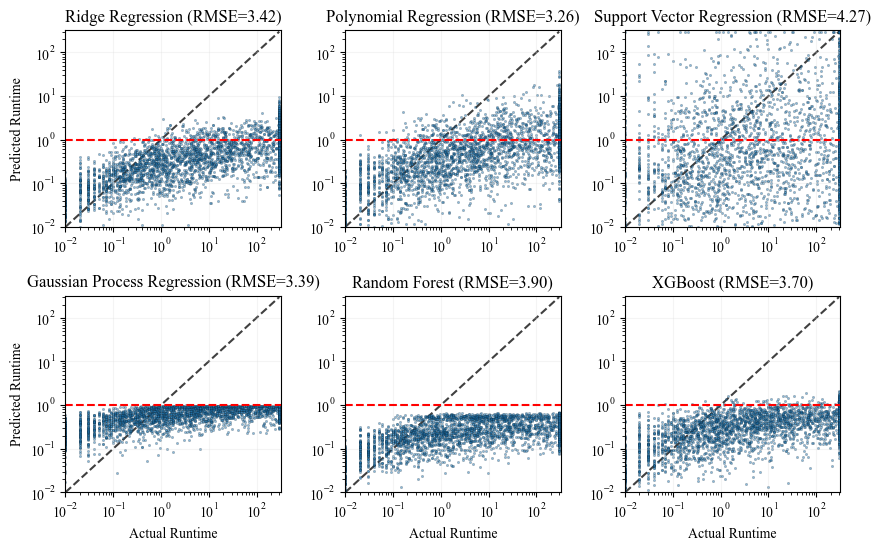

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axs = axs.flatten()

plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[6:12].reset_index(drop=True)

for i, result in plot_df.iterrows():
    ax = axs[i]

    sc = ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=3,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{result["name"]} (RMSE={result["rmse"]:.2f})')
    ax.axhline(y=1, color='red', linestyle='--')

axs[0].set_ylabel("Predicted Runtime")
axs[3].set_ylabel("Predicted Runtime")
axs[3].set_xlabel("Actual Runtime")
axs[4].set_xlabel("Actual Runtime")
axs[5].set_xlabel("Actual Runtime")
plt.subplots_adjust(wspace=0.3, hspace=0.35)
plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

In [32]:
_ = pd.read_pickle("tobit_const_cut_off_1.pkl")

result_df = pd.concat([result_df, _], axis=0).reset_index(drop=True)

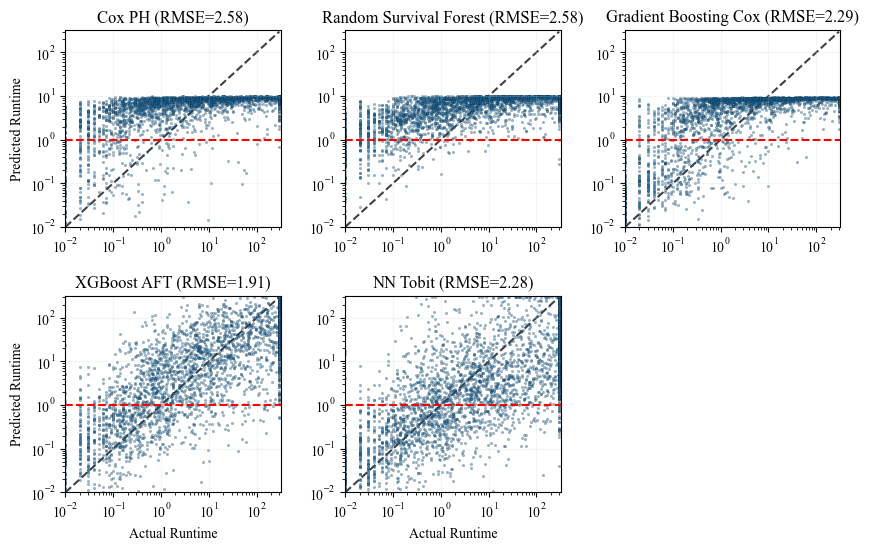

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axs = axs.flatten()

plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[12:].reset_index(drop=True)

for i, result in plot_df.iterrows():
    ax = axs[i]

    sc = ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=3,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{result["name"]} (RMSE={result["rmse"]:.2f})')
    ax.axhline(y=1, color='red', linestyle='--')

axs[0].set_ylabel("Predicted Runtime")
axs[3].set_ylabel("Predicted Runtime")
axs[3].set_xlabel("Actual Runtime")
axs[4].set_xlabel("Actual Runtime")
# axs[5].set_xlabel("Actual Runtime")
axs[5].axis("off")
plt.subplots_adjust(wspace=0.3, hspace=0.35)
plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

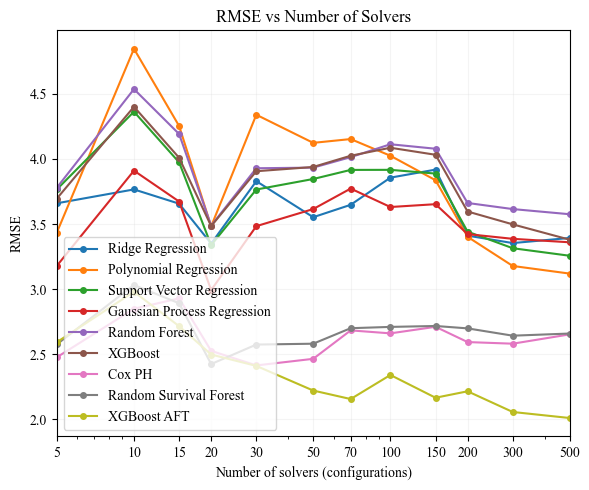

In [22]:
fig, ax = plt.subplots(figsize=(6, 5))

plot_df = result_df.groupby(["name", "solver_number"], sort=False)["rmse"].mean().reset_index()

for name, group in plot_df.groupby("name", sort=False):
    plt.plot(
        group['solver_number'], 
        group['rmse'], 
        'o-', 
        label=name,
        linewidth=1.5,
         markersize=4
    )

plt.xscale('log')
plt.xlabel('Number of solvers (configurations)')
plt.ylabel('RMSE')
plt.legend(loc='best', frameon=True)
plt.xticks(plot_df['solver_number'].unique(), plot_df['solver_number'].unique())
plt.title('RMSE vs Number of Solvers')
plt.tight_layout()
# plt.savefig("rmse_vs_solver_number.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
result_df.pivot_table(
    columns="name",
    index="solver_number",
    values="rmse",
)

name,Cox PH,Gaussian Process Regression,Gradient Boosting Cox,Polynomial Regression,Random Forest,Random Survival Forest,Ridge Regression,Support Vector Regression,XGBoost,XGBoost AFT
solver_number,,,,,,,,,,
5,2.476271,3.178357,3.203854,3.433375,3.967601,2.575738,3.659216,3.765540,3.694975,2.592065
10,2.849093,3.909975,3.939321,4.846019,4.755029,3.031891,3.765776,4.362971,4.400676,2.979613
15,2.928849,3.672654,3.666668,4.252861,4.485292,2.891391,3.656286,3.973658,4.008833,2.715005
20,2.525672,2.992580,3.108994,3.482255,3.527248,2.424348,3.349763,3.337700,3.483886,2.497507
30,2.413845,3.483621,3.507520,4.339432,3.994604,2.574100,3.829087,3.765060,3.905528,2.410206
50,2.464478,3.614953,3.588667,4.123451,3.974132,2.580666,3.552391,3.845856,3.938248,2.220869
70,2.682992,3.772267,3.719279,4.152647,4.046478,2.699780,3.647630,3.915626,4.024429,2.155579
100,2.660078,3.630674,3.636230,4.024458,4.141520,2.709744,3.856304,3.916265,4.085880,2.340414
150,2.710504,3.652372,3.642751,3.836454,4.109745,2.716795,3.917886,3.887499,4.031918,2.165649
